Telco Dataset Churn Predictive Exercise

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

#from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import SVC

In [2]:
# Load dataset
TelcoDs = pd.read_csv('C:\\Users\\Meng\\OneDrive\\Documents\\tamu\\685\\data\\TelcoCustomerChurnTenure2.csv',  na_values=['.'])

In [3]:
# shape
print(TelcoDs.shape) 

(7043, 20)


In [4]:
# head
print(TelcoDs.head(10))

   gender SeniorCitizen Partner Dependents PhoneService     MultipleLines  \
0  Female            No     Yes         No           No  No phone service   
1    Male            No      No         No          Yes                No   
2    Male            No      No         No          Yes                No   
3    Male            No      No         No           No  No phone service   
4  Female            No      No         No          Yes                No   
5  Female            No      No         No          Yes               Yes   
6    Male            No      No        Yes          Yes               Yes   
7  Female            No      No         No           No  No phone service   
8  Female            No     Yes         No          Yes               Yes   
9    Male            No      No        Yes          Yes                No   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No

In [4]:
# check current data type
TelcoDs.dtypes

gender              object
SeniorCitizen       object
Partner             object
Dependents          object
PhoneService        object
MultipleLines       object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
MonthlyCharges      object
TotalCharges        object
Churn_Y1            object
Tenure_Y2            int64
dtype: object

In [7]:
# Dataset Info
TelcoDs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null object
Partner             7043 non-null object
Dependents          7043 non-null object
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null object
TotalCharges        7032 non-null object
Churn_Y1            7043 non-null object
Tenure_Y2           7043 non-null int64
dtypes: int64(1), object(19)
memory usage: 1.1+ MB


In [5]:
# data type converstion for monthly c
TelcoDs[['MonthlyCharges']] = TelcoDs[['MonthlyCharges']].apply(lambda x: x.str.replace('$','')).astype(float)

In [7]:
# data type converstion
TelcoDs[['TotalCharges']] = TelcoDs[['TotalCharges']].apply(lambda x: x.str.replace('$','')).astype(str)
TelcoDs[['TotalCharges']] = TelcoDs[['TotalCharges']].apply(lambda x: x.str.replace(',','')).astype(float)


In [8]:
# descriptions
TelcoDs.fillna(0, inplace=True)
print(TelcoDs.describe())

       MonthlyCharges  TotalCharges    Tenure_Y2
count     7043.000000   7043.000000  7043.000000
mean        64.761692   2279.734304    32.371149
std         30.090047   2266.794470    24.559481
min         18.250000      0.000000     0.000000
25%         35.500000    398.550000     9.000000
50%         70.350000   1394.550000    29.000000
75%         89.850000   3786.600000    55.000000
max        118.750000   8684.800000    72.000000


In [9]:
# contract distribution
print(TelcoDs.groupby('Contract').size())

Contract
Month-to-month    3875
One year          1473
Two year          1695
dtype: int64


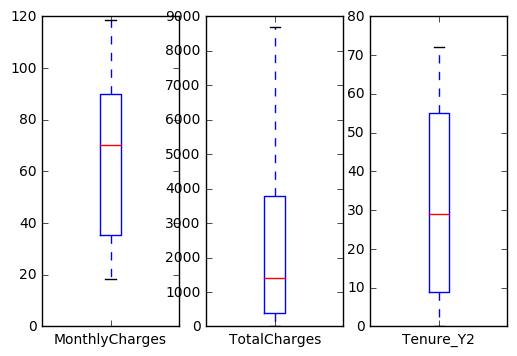

In [10]:
# box and whisker plots
TelcoDs.plot(kind='box', subplots=True, layout=(1,3), sharex=False, sharey=False)
plt.show()

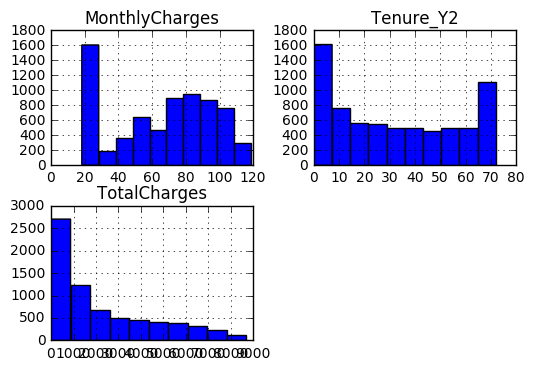

In [11]:
# histograms
TelcoDs.hist()
plt.show()

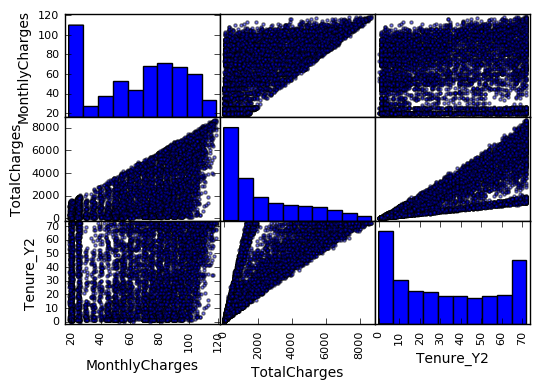

In [14]:
# scatter plot matrix
from pandas.tools.plotting import scatter_matrix
scatter_matrix(TelcoDs)
plt.show()

In [15]:
# add "Churn" column: 1 represents Churn, 0 represents not
TelcoDs['Churn'] = (TelcoDs.Churn_Y1 =='Yes').astype(int)

In [16]:
# Data Exploration by Churn
TelcoDs.groupby('Churn').mean()

,MonthlyCharges,TotalCharges,Tenure_Y2
Churn,,,
0,61.265124,2549.911442,37.569965
1,74.441332,1531.796094,17.979133


In [17]:
# Data Exploration by Internet Services
TelcoDs.groupby('InternetService').mean()

,MonthlyCharges,TotalCharges,Tenure_Y2,Churn
InternetService,,,,
DSL,58.102169,2115.411338,32.821561,0.189591
Fiber optic,91.500129,3205.304570,32.917959,0.418928
No,21.079194,662.604784,30.547182,0.074050


In [18]:
# Data Exploration by Contract
TelcoDs.groupby('Contract').mean()

,MonthlyCharges,TotalCharges,Tenure_Y2,Churn
Contract,,,,
Month-to-month,66.398490,1369.254581,18.036645,0.427097
One year,65.048608,3032.622878,42.044807,0.112695
Two year,60.770413,3706.934336,56.735103,0.028319


In [21]:
# show plots in the notebook
%matplotlib inline

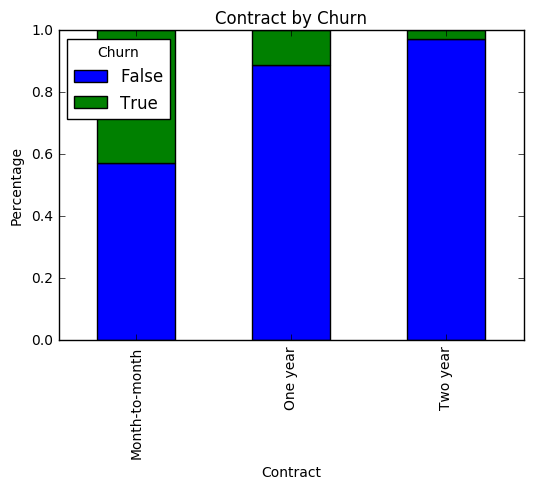

In [22]:
# Let's see contract type by Churn
Churn_contract_type = pd.crosstab(TelcoDs.Contract, TelcoDs.Churn.astype(bool))
Churn_contract_type.div(Churn_contract_type.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Contract by Churn')
plt.xlabel('Contract')
plt.ylabel('Percentage')

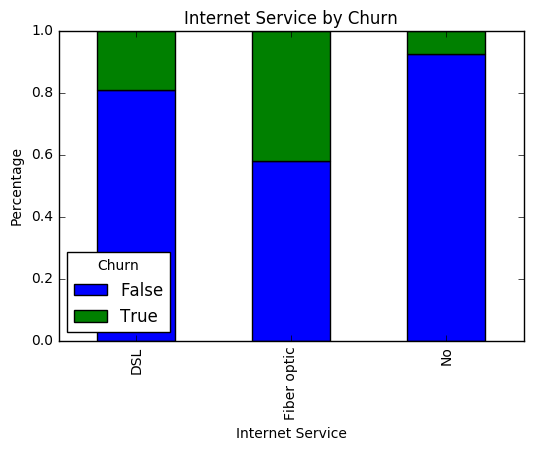

In [23]:
# Let's see Internet Service by Churn
Churn_internet_type = pd.crosstab(TelcoDs.InternetService, TelcoDs.Churn.astype(bool))
Churn_internet_type.div(Churn_internet_type.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Internet Service by Churn')
plt.xlabel('Internet Service')
plt.ylabel('Percentage')

In [30]:
# create dataframes with an intercept column and dummy variables for
# gender, SeniorCitizen, Partner, Dependents
y, X = dmatrices('Churn ~ gender + SeniorCitizen + Partner + Dependents + PhoneService + PhoneService/MultipleLines + InternetService + \
                 InternetService/OnlineSecurity + InternetService/OnlineBackup + InternetService/DeviceProtection + InternetService/TechSupport + InternetService/StreamingTV + InternetService/StreamingMovies + Contract + PaperlessBilling + \
                 PaymentMethod + MonthlyCharges + TotalCharges + Tenure_Y2 + Tenure_Y2*Tenure_Y2', TelcoDs, return_type="dataframe")
print (X.columns)

Index(['Intercept', 'gender[T.Male]', 'SeniorCitizen[T.Yes]', 'Partner[T.Yes]',
       'Dependents[T.Yes]', 'PhoneService[T.Yes]',
       'InternetService[T.Fiber optic]', 'InternetService[T.No]',
       'Contract[T.One year]', 'Contract[T.Two year]',
       'PaperlessBilling[T.Yes]', 'PaymentMethod[T.Credit card (automatic)]',
       'PaymentMethod[T.Electronic check]', 'PaymentMethod[T.Mailed check]',
       'PhoneService[No]:MultipleLines[T.No phone service]',
       'PhoneService[Yes]:MultipleLines[T.No phone service]',
       'PhoneService[No]:MultipleLines[T.Yes]',
       'PhoneService[Yes]:MultipleLines[T.Yes]',
       'InternetService[DSL]:OnlineSecurity[T.No internet service]',
       'InternetService[Fiber optic]:OnlineSecurity[T.No internet service]',
       'InternetService[No]:OnlineSecurity[T.No internet service]',
       'InternetService[DSL]:OnlineSecurity[T.Yes]',
       'InternetService[Fiber optic]:OnlineSecurity[T.Yes]',
       'InternetService[No]:OnlineSecurity[T.

In [31]:
# flatten y into a 1-D array
y = np.ravel(y)

In [32]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.8100241374414312

In [33]:
# what percentage of Churn?
y.mean()

0.26536987079369589

<I>26.5 % of the customers had churned</I>, which means that we could obtain 73.5 % accuracy by always predicting "no". 
So we're doing better than the null error rate, but not by much.
Let's examine the coefficients to see what we learn.

In [34]:
# examine the coefficients
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))

,0,1
0,Intercept,[-0.0518598575617]
1,gender[T.Male],[-0.0215501207439]
2,SeniorCitizen[T.Yes],[0.23931304857]
3,Partner[T.Yes],[0.0305847500659]
4,Dependents[T.Yes],[-0.163355835376]
5,PhoneService[T.Yes],[-0.35828801336]
6,InternetService[T.Fiber optic],[0.455538900588]
7,InternetService[T.No],[-0.114266276812]
8,Contract[T.One year],[-0.470583149911]
9,Contract[T.Two year],[-0.801927196135]


In [35]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print (predicted)

[ 0.  0.  0. ...,  0.  0.  0.]


In [37]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print (probs)

[[ 0.86914271  0.13085729]
 [ 0.90020077  0.09979923]
 [ 0.58528988  0.41471012]
 ..., 
 [ 0.84264175  0.15735825]
 [ 0.99149081  0.00850919]
 [ 0.69647578  0.30352422]]


In [38]:
# generate evaluation metrics
print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs[:, 1]))

0.799810695693
0.835813975054


In [39]:
print (metrics.confusion_matrix(y_test, predicted))
print (metrics.classification_report(y_test, predicted))

[[1392  168]
 [ 255  298]]
             precision    recall  f1-score   support

        0.0       0.85      0.89      0.87      1560
        1.0       0.64      0.54      0.58       553

avg / total       0.79      0.80      0.79      2113



In [40]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print (scores)
print (scores.mean())

[ 0.7929078   0.81276596  0.80567376  0.8212766   0.79119318  0.79545455
  0.80681818  0.81392045  0.80397727  0.80654339]
0.805053113533


In [41]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [43]:
from sklearn.feature_selection import RFE

In [45]:
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(X, y)
print(fit.n_features_)
print(fit.support_)
print(fit.ranking_)

3
[False False False False False False  True False  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]
[17 30 23 33 15 11  1 10  1  1 13 19  5 28 24 36 43 25 45 46 18  4  3 49 51
 47  6  7 12 37 38 39  2 29 31 52 50 55 21  8  9 48 54 53 22 32 14 44 40 41
 16 26 20 42 34 35 27]


In [47]:
model = model.fit(X, y)
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_),fit.ranking_)))

,0,1,2
0,Intercept,[-0.0518598575617],17
1,gender[T.Male],[-0.0215501207439],30
2,SeniorCitizen[T.Yes],[0.23931304857],23
3,Partner[T.Yes],[0.0305847500659],33
4,Dependents[T.Yes],[-0.163355835376],15
5,PhoneService[T.Yes],[-0.35828801336],11
6,InternetService[T.Fiber optic],[0.455538900588],1
7,InternetService[T.No],[-0.114266276812],10
8,Contract[T.One year],[-0.470583149911],1
9,Contract[T.Two year],[-0.801927196135],1
